In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wsdm-kkbox/songs.csv
/kaggle/input/wsdm-kkbox/members.csv
/kaggle/input/wsdm-kkbox/train.csv
/kaggle/input/wsdm-kkbox/test.csv
/kaggle/input/wsdm-kkbox/song_extra_info.csv


In [41]:
%matplotlib
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import gc
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier

Using matplotlib backend: agg


In [ ]:
#learning from
#https://www.kaggle.com/rohandx1996/recommendation-system-with-83-accuracy-lgbm

In [17]:
from subprocess import check_output

train = pd.read_csv('/kaggle/input/wsdm-kkbox/train.csv')
test = pd.read_csv('/kaggle/input/wsdm-kkbox/test.csv')
songs = pd.read_csv('/kaggle/input/wsdm-kkbox/songs.csv')
members = pd.read_csv('/kaggle/input/wsdm-kkbox/members.csv')


In [18]:
train_members = pd.merge(train, members, on='msno', how='inner')

In [19]:
train_members_songs = pd.merge(train_members, songs, on='song_id', how='outer')

In [20]:
train_members_songs

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0,1.0,0.0,NaN,7.0,20120102.0,20171005.0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0.0,15.0,18.0,male,4.0,20151220.0,20170930.0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
2,xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1.0,1.0,0.0,NaN,7.0,20120804.0,20171004.0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1.0,5.0,21.0,female,9.0,20110808.0,20170917.0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0.0,6.0,33.0,female,9.0,20070323.0,20170915.0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9313819,NaN,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20192.0,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
9313820,NaN,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273391.0,465,紀文惠 (Justine Chi),NaN,NaN,3.0
9313821,NaN,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445172.0,1609,Various Artists,NaN,NaN,52.0
9313822,NaN,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172669.0,465,Peter Paul & Mary,NaN,NaN,52.0


In [21]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_members_songs = pd.merge(test_members, songs, on='song_id', how='outer')

In [22]:
del test_members
del train_members

In [23]:
train_members_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9313824 entries, 0 to 9313823
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  float64
 6   city                    float64
 7   bd                      float64
 8   gender                  object 
 9   registered_via          float64
 10  registration_init_time  float64
 11  expiration_date         float64
 12  song_length             float64
 13  genre_ids               object 
 14  artist_name             object 
 15  composer                object 
 16  lyricist                object 
 17  language                float64
dtypes: float64(8), object(10)
memory usage: 1.3+ GB


In [24]:
#train_members_songs[train_members_songs['msmo'].notnull()]['msmo'].astype('string')

In [25]:
#ax = sns.countplot(y=train_members_songs.dtypes, data=train_members_songs)

In [26]:
train_members_songs.columns.to_series().groupby(train_members_songs.dtypes).groups

{dtype('float64'): Index(['target', 'city', 'bd', 'registered_via', 'registration_init_time',
        'expiration_date', 'song_length', 'language'],
       dtype='object'),
 dtype('O'): Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
        'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
        'lyricist'],
       dtype='object')}

In [27]:
test_members_songs.columns.to_series().groupby(test_members_songs.dtypes).groups

{dtype('float64'): Index(['id', 'city', 'bd', 'registered_via', 'registration_init_time',
        'expiration_date', 'song_length', 'language'],
       dtype='object'),
 dtype('O'): Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
        'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
        'lyricist'],
       dtype='object')}

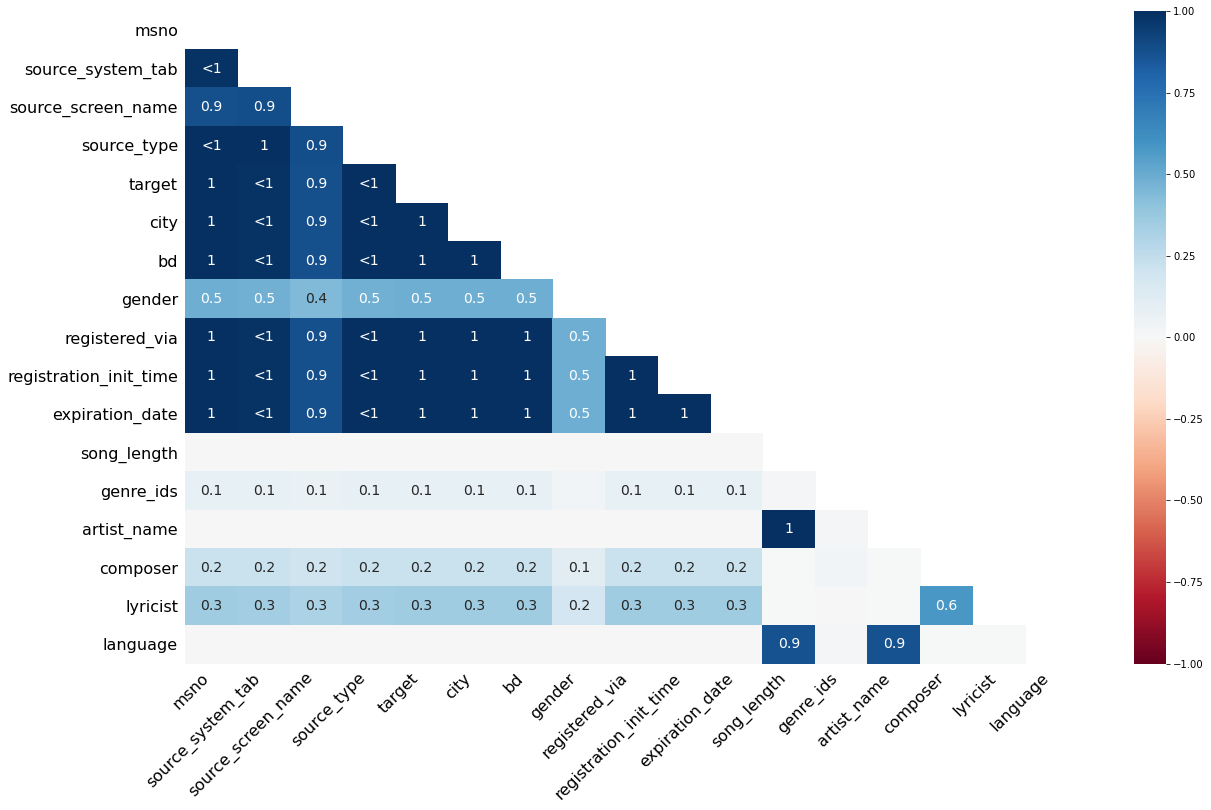

In [28]:
msno.heatmap(train_members_songs)
#msno.matrix(train_members_songs)

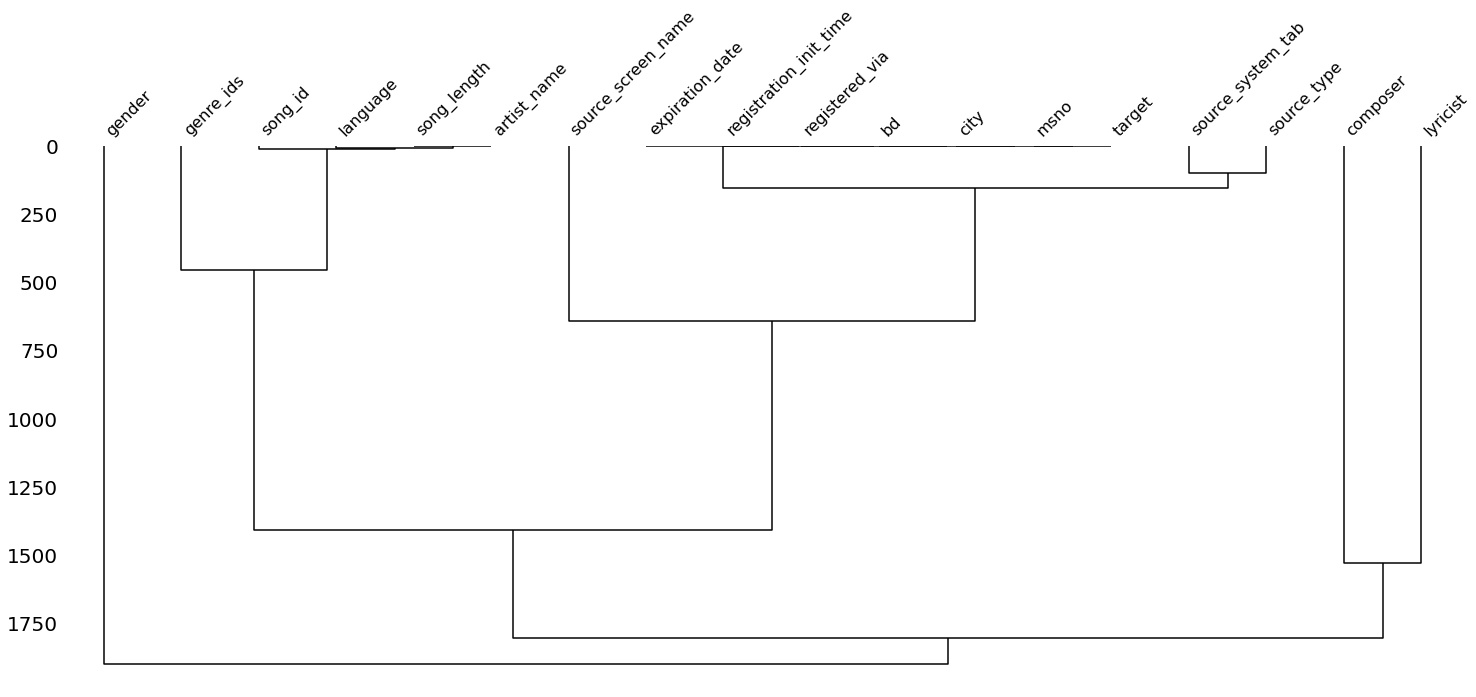

In [29]:
msno.dendrogram(train_members_songs)

In [30]:
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_members_songs)
check_missing_values(test_members_songs)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 1936406
source_system_tab : 1961255
source_screen_name : 2351210
source_type : 1957945
target : 1936406
city : 1936406
bd : 1936406
gender : 4897885
registered_via : 1936406
registration_init_time : 1936406
expiration_date : 1936406
song_length : 114
genre_ids : 205338
artist_name : 114
composer : 2591558
lyricist : 4855358
language : 150
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2071581
msno : 2071581
source_system_tab : 2080023
source_screen_name : 2234464
source_type : 2078878
city : 2071581
bd : 2071581
gender : 3123805
register

In [31]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))
       

replace_Nan_non_object(train_members_songs) 
replace_Nan_non_object(test_members_songs)

In [32]:
#--- memory consumed by train dataframe ---
mem = train_members_songs.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
 
#--- memory consumed by test dataframe ---
mem = test_members_songs.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1350.117919921875 MB
Memory consumed by test set      :   670.9216995239258 MB


In [34]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_members_songs)
change_datatype(test_members_songs)

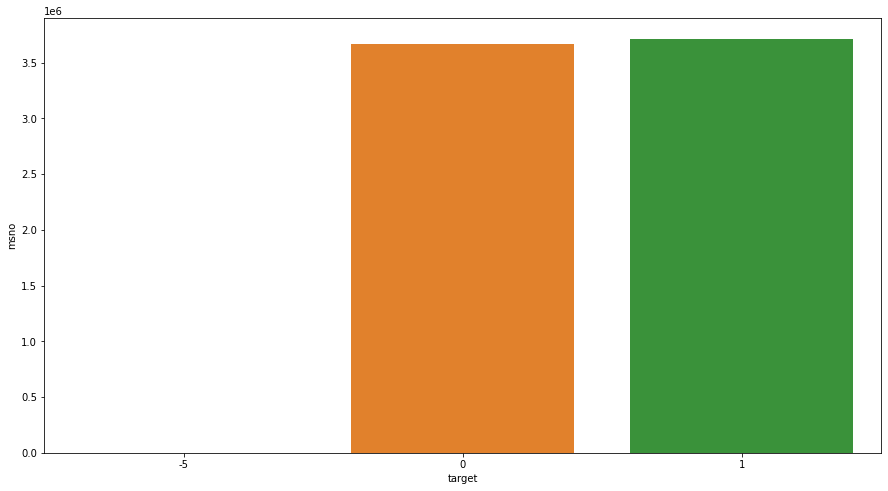

In [36]:
data = train_members_songs.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

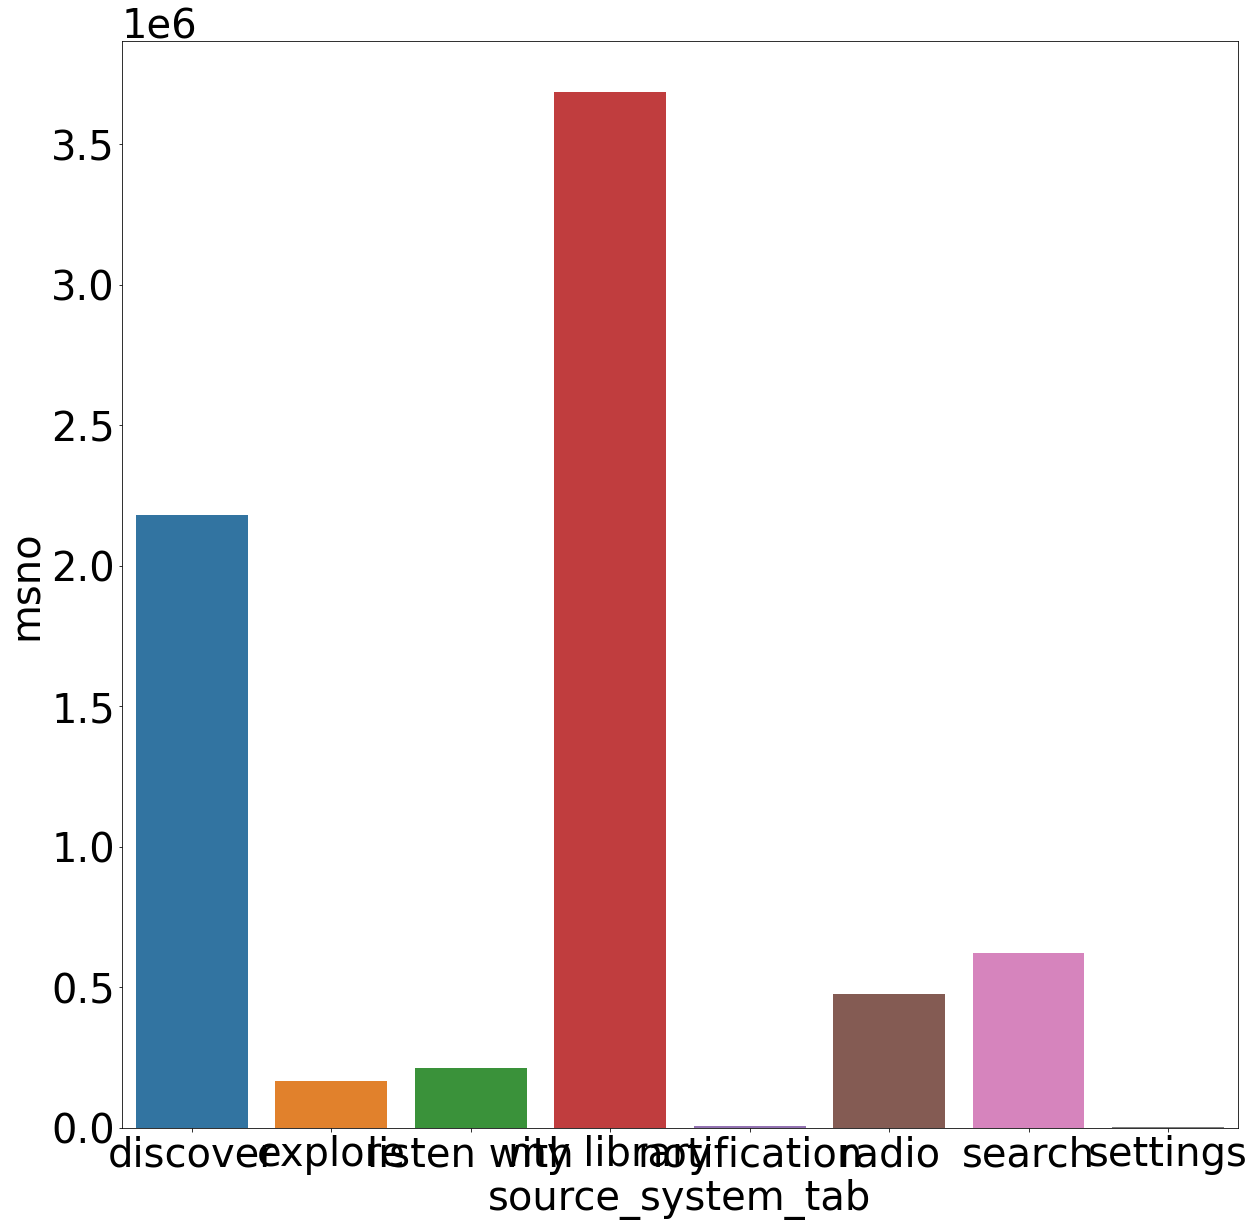

In [38]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
data=train_members_songs.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data)

[Text(0, 0, 'Album more'),
 Text(0, 0, 'Artist more'),
 Text(0, 0, 'Concert'),
 Text(0, 0, 'Discover Chart'),
 Text(0, 0, 'Discover Feature'),
 Text(0, 0, 'Discover Genre'),
 Text(0, 0, 'Discover New'),
 Text(0, 0, 'Explore'),
 Text(0, 0, 'Local playlist more'),
 Text(0, 0, 'My library'),
 Text(0, 0, 'My library_Search'),
 Text(0, 0, 'Online playlist more'),
 Text(0, 0, 'Others profile more'),
 Text(0, 0, 'Payment'),
 Text(0, 0, 'Radio'),
 Text(0, 0, 'Search'),
 Text(0, 0, 'Search Home'),
 Text(0, 0, 'Search Trends'),
 Text(0, 0, 'Self profile more'),
 Text(0, 0, 'Unknown')]

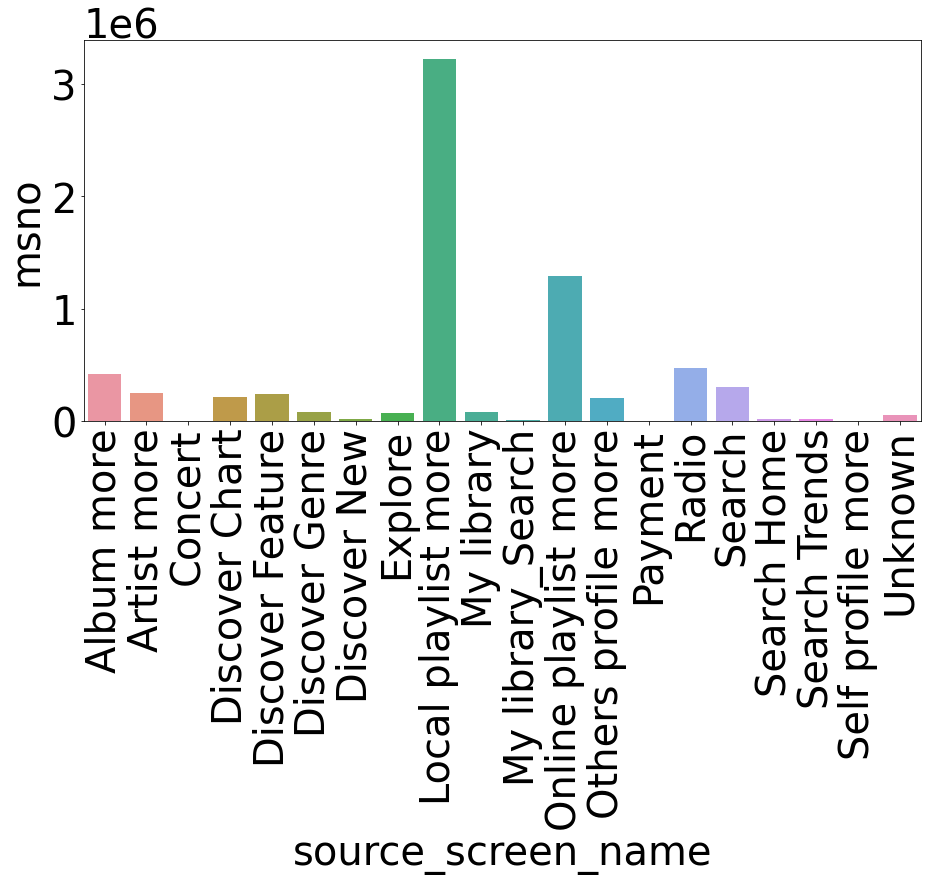

In [39]:
data = train_members_songs.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

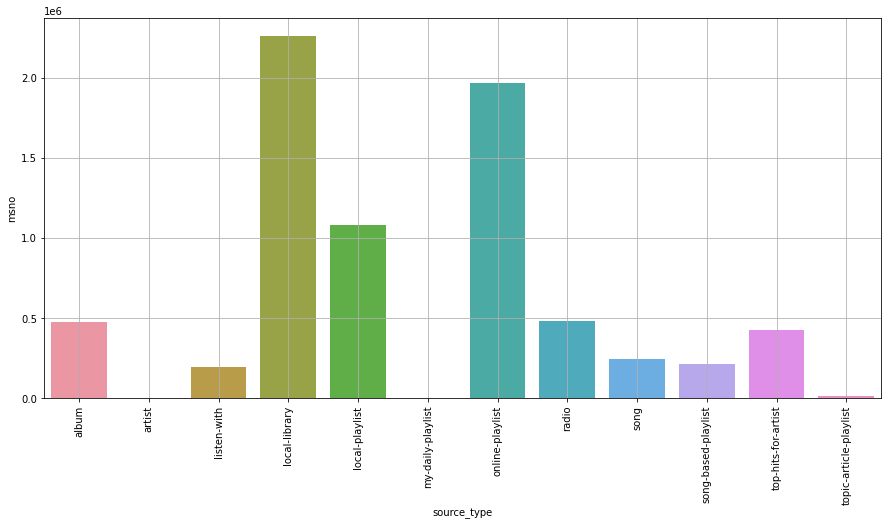

In [43]:
data = train_members_songs.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(True)

[Text(0, 0, '-5'),
 Text(0, 0, '-1'),
 Text(0, 0, '3'),
 Text(0, 0, '10'),
 Text(0, 0, '17'),
 Text(0, 0, '24'),
 Text(0, 0, '31'),
 Text(0, 0, '38'),
 Text(0, 0, '45'),
 Text(0, 0, '52'),
 Text(0, 0, '59')]

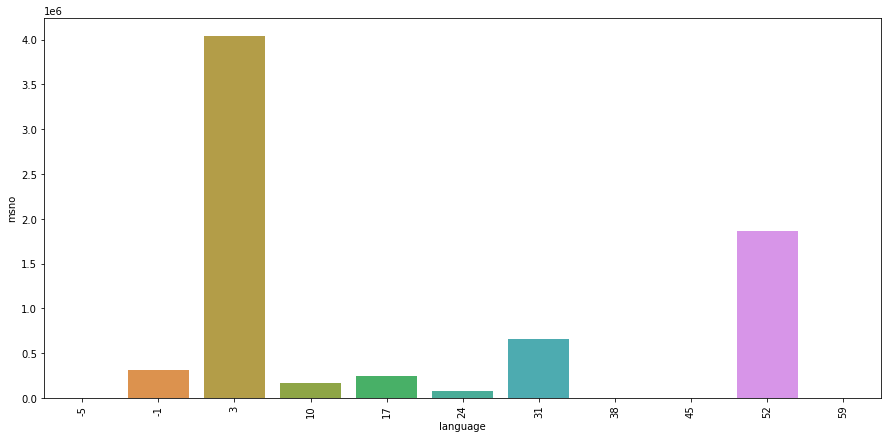

In [44]:
data = train_members_songs.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='language', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '13')]

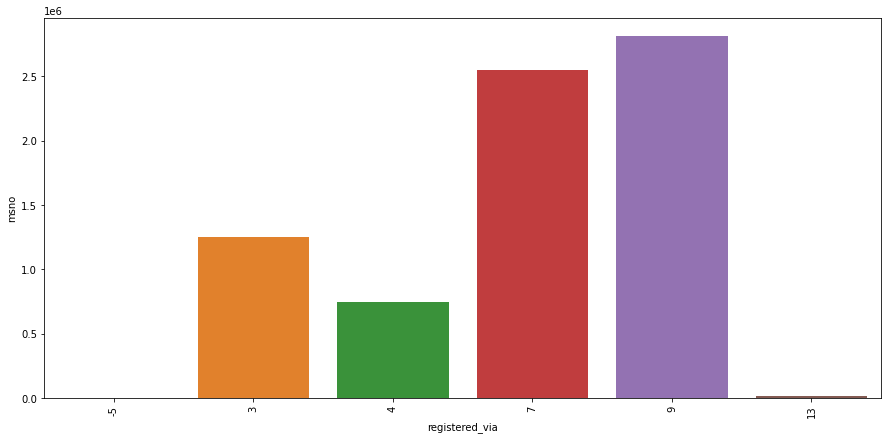

In [45]:
data = train_members_songs.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='registered_via', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'language'],
      dtype='object')


[Text(0, 0, '-5'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

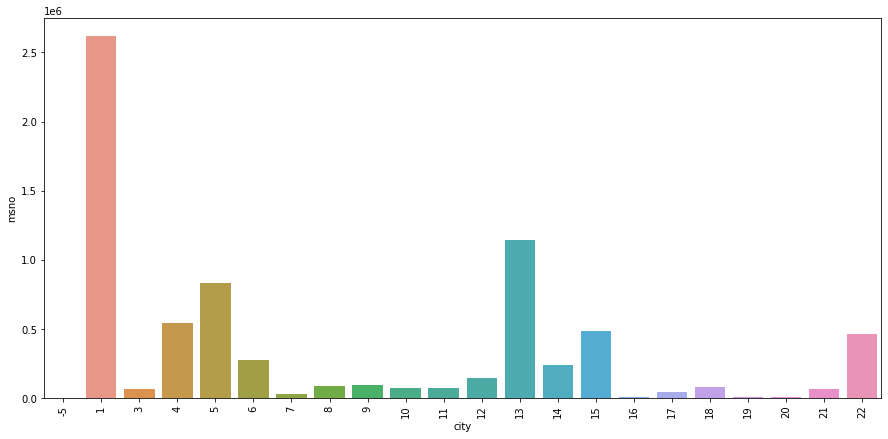

In [48]:
print(train_members_songs.columns)
data = train_members_songs.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='city', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

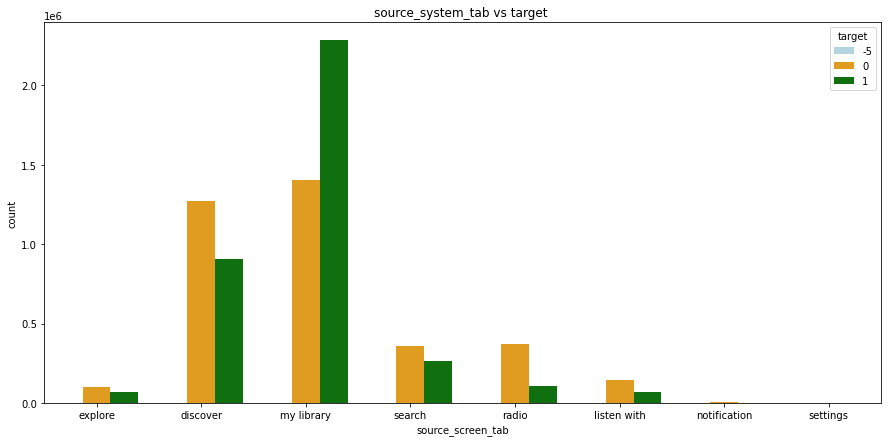

In [49]:
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_members_songs,palette=['lightblue','orange','green'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

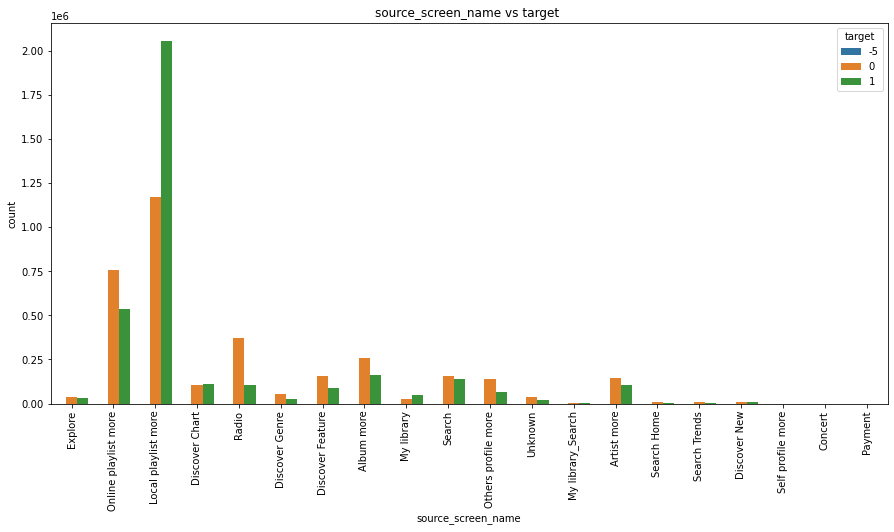

In [50]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_screen_name",data=train_members_songs,hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.xticks(rotation='90')
plt.show()

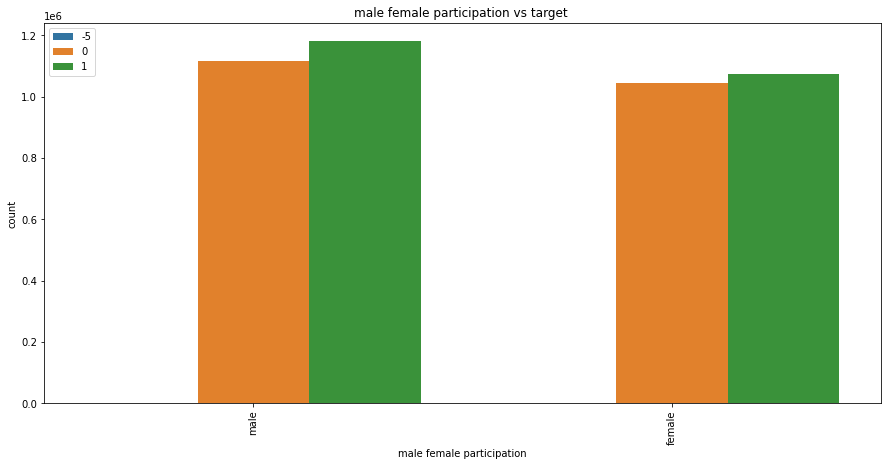

In [51]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_members_songs,hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.legend(loc='upper left')
plt.show()

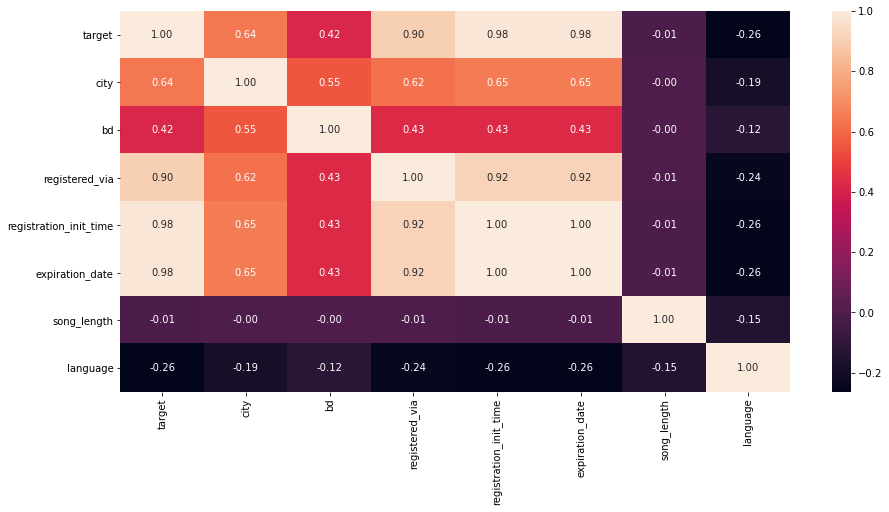

In [52]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.heatmap(data=train_members_songs.corr(),annot=True,fmt=".2f")

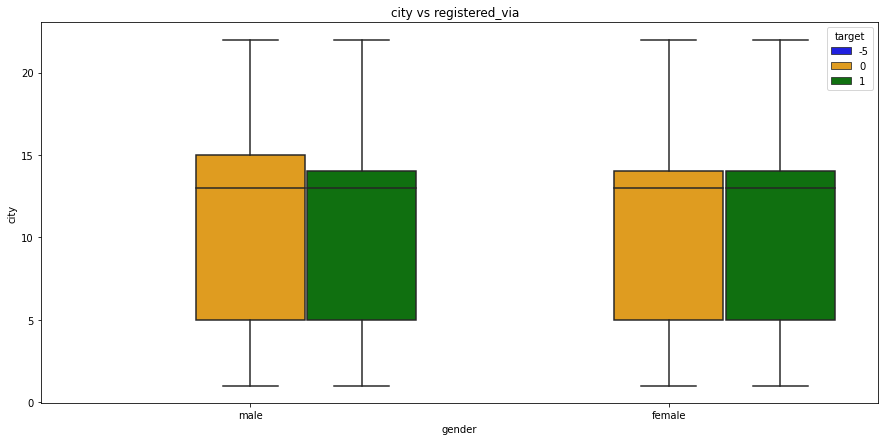

In [53]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="gender",y="city",data=train_members_songs,palette=['blue','orange','green'],hue="target")
plt.xlabel("gender")
plt.ylabel("city")
plt.title("city vs registered_via  ")
plt.show()

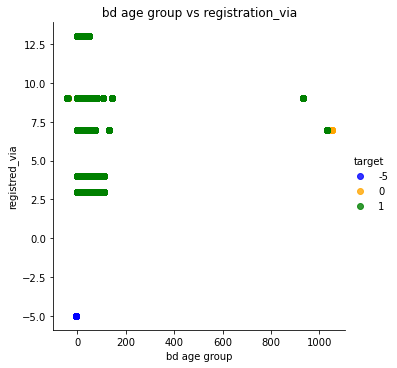

In [54]:
ax=sns.lmplot(x="bd",y="registered_via",data=train_members_songs,palette=['blue','orange','green'],hue="target",fit_reg=False)
plt.xlabel("bd age group")
plt.ylabel("registred_via")
plt.title(" bd age group vs registration_via ")
plt.show()

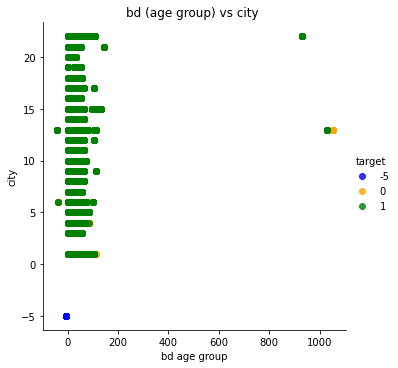

In [55]:
ax=sns.lmplot(x="bd",y="city",data=train_members_songs,palette=['blue','orange','green'],hue="target",fit_reg=False)
plt.xlabel("bd age group")
plt.ylabel("city")
plt.title("bd (age group) vs city ")
plt.show()

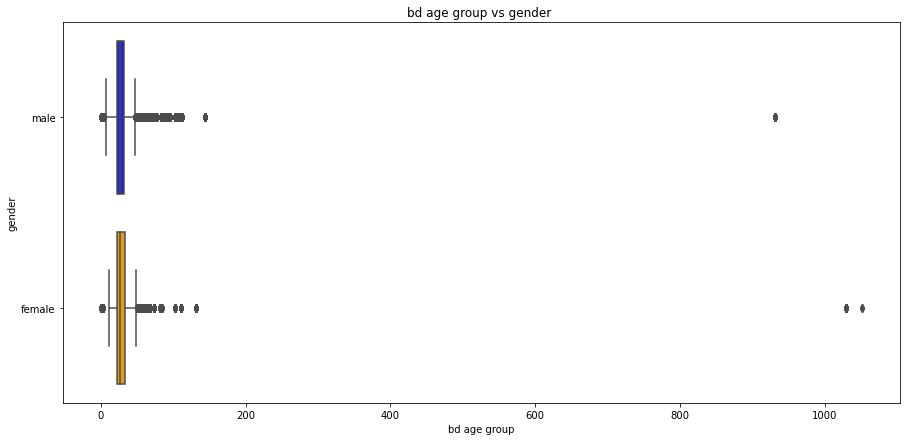

In [57]:
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="bd",y="gender",data=train_members_songs,palette=['blue','orange','green'])
plt.xlabel("bd age group")
plt.ylabel("gender")
plt.title("bd age group vs gender ")
plt.show()

In [ ]:

def remove_outlier(df_in, col_name):

    #q1 = df_in[col_name].quantile(0.25)
    #q3 = df_in[col_name].quantile(0.75)
    #iqr = q3-q1 #Interquartile range
    fence_low  = 12
    fence_high = 45
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
df_final_train=remove_outlier(train_members_songs,'bd')